# This is a notebook which implements Grover's unstructured database search algorithm. It is capable of searching for multiple correct answers in the database. These correct answers are defined by the user, as is the size of the database.

In [2]:
# import relevant libraries

from qiskit import QuantumCircuit, QuantumRegister
from qiskit import Aer
from qiskit.visualization import array_to_latex
from qiskit import compiler
from qiskit.quantum_info import Statevector, random_statevector
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit import IBMQ
from qiskit import execute
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

import numpy as np
import math

IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

### We start by defining a method which creates the oracle gate corresponding to a passed set of bit strings which correspond to the answers of the search problem

In [6]:
# define oracle, which inverts the phase of specific input bit string corresponding to answer to search problem

def create_oracle(answers):
    
    if type(answers) != list:
        answers = [answers]
    if not all(type(answer) == str for answer in answers):
        raise Exception("Error - bit strings passed to create_oracle method must be of type string!")
    
    bit_length = len(answers[0])
    # generate the quantum circuit
    # this is done using the multiple-controlled Z rotation gate, rotating at 180 deg
    result = QuantumCircuit(bit_length)
    for answer in answers:
    
        for index, bit in enumerate(answer[::-1]): # transform basis so that answer is now 11..11
            
            if bit == '0':
                
                result.x(int(index))
                
        result.mcrz(np.pi, range(bit_length - 1), bit_length - 1) # flip the 11..11 state
        
        for index, bit in enumerate(answer[::-1]): # perform inverse transform
            
            if bit == '0':
                
                result.x(int(index))
                
        result.barrier(range(bit_length)) # place a barrier between gates for different answer for clarity
    
    return result

### We test whether the gate is the correct one by printing its unitary matrix representation.

In [7]:
def display_unitary(qc, prefix=""):
    """Simulates a simple circuit and display its matrix representation.
    Args:
        qc (QuantumCircuit): The circuit to compile to a unitary matrix
        prefix (str): Optional LaTeX to be displayed before the matrix
    Returns:
        None (displays matrix as side effect)
    """
    sim = Aer.get_backend('aer_simulator')
    
    # Next, we'll create a copy of the circuit and work on
    # that so we don't change anything as a side effect
    qc = qc.copy()
    
    # Tell the simulator to save the unitary matrix of this circuit
    qc.save_unitary()
    unitary = sim.run(qc).result().get_unitary()
    display(array_to_latex(unitary, prefix=prefix))

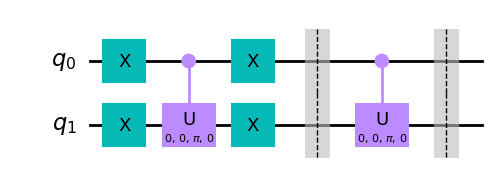

<IPython.core.display.Latex object>

In [8]:
answer_strings = ['00', '11']
oracle = create_oracle(answer_strings)
display(oracle.draw(output='mpl'))
display_unitary(oracle, "U_\\text{oracle}=")

### Next, we create the gate performing the second operation in each Grover iteration -- the reflection gate. We have implemented this as a reflection about the hyper-plane perpendicular to the equal superposition state, rather than about the superposition state itself, but this should not have any effect on the final result since global phase factors are irrelevant.

In [9]:
# generate gate which reflects quantum state across equal superposition state
def generate_reflection_gate(bit_length):
    
    result = QuantumCircuit(bit_length)
    
    # transform basis so that superposition state corresponds to 11..11 state
    result.h(range(bit_length))
    result.x(range(bit_length))
    
    # apply controlled z rotation gate at 180 deg
    if bit_length == 1:
        result.z(0)
    else:
        result.mcrz(np.pi, range(bit_length - 1), bit_length - 1)
    
    # inverse-transform basis 
    result.x(range(bit_length))
    result.h(range(bit_length))
    
    # overall, the result is a reflection over the plane perpendicular to the superposition state
    # but this is irrelevant since global phase factors do not alter measurement probabilities
    return result

### We now show that the reflector gate indeed works. To do this, we first generate a random state vector and calculate the inner products of that vector with each of the Hadamard basis vectors. We then evolve the random state vector with the reflector, and show that the inner products have changed signs accordingly

In [12]:
# generate random state vector

no_qubits = 3
random_vector = random_statevector(2**no_qubits)
random_vector.draw(output='latex')

<IPython.core.display.Latex object>

In [13]:
# measure the inner products with each of the Hadamard basis state

hadamard_transformer = QuantumCircuit(no_qubits)
hadamard_transformer.h(range(no_qubits))
basis_states = []
original_inner_products = []

for basis_state_no in range(2**no_qubits):
    
    vector = np.zeros(2**no_qubits)
    vector[basis_state_no] = 1
    basis_states.append(Statevector(vector).evolve(hadamard_transformer))
    print("Inner product with ")
    display(basis_states[-1].draw(output='latex'))
    original_inner_products.append(basis_states[-1].inner(random_vector))
    print("is ", original_inner_products[-1], "\n\n")

Inner product with 


<IPython.core.display.Latex object>

is  (0.24323388833652443+0.09138545942206384j) 


Inner product with 


<IPython.core.display.Latex object>

is  (-0.008639109872973935-0.33683851177647733j) 


Inner product with 


<IPython.core.display.Latex object>

is  (0.17763895632758875-0.23714028199460863j) 


Inner product with 


<IPython.core.display.Latex object>

is  (-0.13055692521331425-0.020493288173469126j) 


Inner product with 


<IPython.core.display.Latex object>

is  (0.5295428558479842-0.18195334092320065j) 


Inner product with 


<IPython.core.display.Latex object>

is  (0.22186439210279818+0.33372864714077694j) 


Inner product with 


<IPython.core.display.Latex object>

is  (-0.0592778628886064-0.43365017345268075j) 


Inner product with 


<IPython.core.display.Latex object>

is  (0.1111383806477386-0.18882692585878036j) 




In [14]:
# now we evolve the state using the reflector gate and find the new inner products
reflector_gate = generate_reflection_gate(no_qubits)
reflected_vector = random_vector.evolve(reflector_gate)
reflected_inner_products = []

for basis_state in basis_states:
    print("Inner product with ")
    display(basis_state.draw(output='latex'))
    reflected_inner_products.append(basis_state.inner(reflected_vector))
    print("is ", reflected_inner_products[-1], "\n\n")

Inner product with 


<IPython.core.display.Latex object>

is  (-0.24323388833652432-0.0913854594220638j) 


Inner product with 


<IPython.core.display.Latex object>

is  (-0.008639109872973963-0.33683851177647717j) 


Inner product with 


<IPython.core.display.Latex object>

is  (0.17763895632758867-0.23714028199460851j) 


Inner product with 


<IPython.core.display.Latex object>

is  (-0.13055692521331416-0.020493288173469085j) 


Inner product with 


<IPython.core.display.Latex object>

is  (0.529542855847984-0.18195334092320053j) 


Inner product with 


<IPython.core.display.Latex object>

is  (0.2218643921027981+0.3337286471407767j) 


Inner product with 


<IPython.core.display.Latex object>

is  (-0.0592778628886064-0.4336501734526805j) 


Inner product with 


<IPython.core.display.Latex object>

is  (0.11113838064773848-0.1888269258587803j) 




In [15]:
# print the basis state for which the expansion coeeficient's sign has been flipped

for index, basis_state in enumerate(basis_states):

    if math.isclose(original_inner_products[index].real, -1.0 * reflected_inner_products[index].real) and math.isclose(original_inner_products[index].imag, -1.0 * reflected_inner_products[index].imag):

        print("Expansion coeficient has been flipped for following Hadamard basis state:")
        display(basis_state.draw(output='latex'))
        


Expansion coeficient has been flipped for following Hadamard basis state:


<IPython.core.display.Latex object>

### We now combine everything to create the overall quantum circuit which solves the search problem.

In [16]:
# define which are the correct answers
answers = ['011', '110']

# create the oracle and reflector gates
no_qubits = len(answers[0])
oracle = create_oracle(answers)
reflector = generate_reflection_gate(no_qubits)

# determine how many grover iterations must be performed
initial_angle = math.asin(math.sqrt(len(answers) / (2**no_qubits)))
no_grover_iterations = int(0.25 * math.pi / initial_angle - 0.5)

# create the full quantum circuit
grover_circuit = QuantumCircuit(no_qubits)
grover_circuit.h(range(no_qubits))
grover_circuit.barrier()
for grover_iteration in range(no_grover_iterations):
    grover_circuit = grover_circuit.compose(oracle)
    grover_circuit = grover_circuit.compose(reflector)
    grover_circuit.barrier()
grover_circuit.measure_all()

The probability of finding a correct answer is 100.0 %


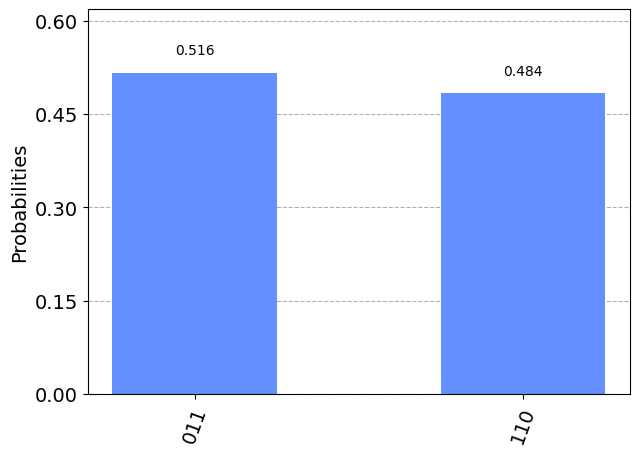

In [17]:
# simulate the operation of the quantum circuit

simulator = Aer.get_backend('aer_simulator')
results = simulator.run(grover_circuit).result().get_counts()
total_simulations = 0
for result in results:
    total_simulations += results[result]

success_probability = 0
for answer in answers:
    success_probability += results[answer]
print("The probability of finding a correct answer is", success_probability/total_simulations * 100, "%")
plot_histogram(results)


### We can also run the algorithm on a real quantum circuit.

In [20]:
provider = IBMQ.get_provider('ibm-q')
print("All available backends:")
for backend in provider.backends():
    print(backend)
backend_lb = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= no_qubits and
                                   not b.configuration().simulator and b.status().operational==True))
print("\nLeast busy backend: ", backend_lb)

All available backends:
ibmq_qasm_simulator
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila
ibm_nairobi
ibm_oslo

Least busy backend:  ibmq_belem
<class 'qiskit.providers.ibmq.ibmqbackend.IBMQBackend'>


In [21]:
backend = backend_lb

In [22]:
job = execute(grover_circuit, backend)
job_monitor(job)

Job Status: job is queued (40)    

IBMQJobApiError: '"HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/631b0f21b11a63c0d759334e/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x1659ad7f0>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'

In [23]:
job_monitor(job)

Job Status: job has successfully run


The probability of finding a correct answer is 48.199999999999996 %


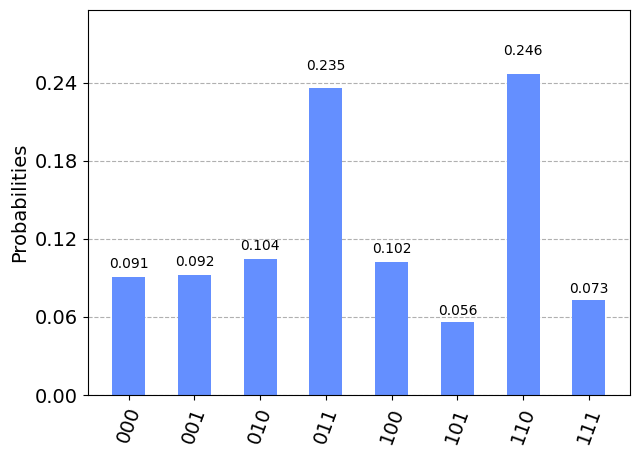

In [24]:
results_qc = job.result().get_counts(grover_circuit)
total_simulations = 0
for result in results_qc:
    total_simulations += results_qc[result]

success_probability = 0
for answer in answers:
    success_probability += results_qc[answer]
print("The probability of finding a correct answer is", success_probability/total_simulations * 100, "%")
plot_histogram(job.result().get_counts(grover_circuit))